# Assignment 7 - Graph drawing and network analysis

An important step to gain insight from data is to recognize existing, known structure and incorporate it into your analysis.
Graph structures as a mathematical representation of connectedness can be found in a wide variety of practical settings.

In this assignment we hope to enable you to:

* Understand what graphs are and how to recognize graph-type relationships in your data
* Use standard graph analysis techniques and tools to get answers for data analysis questions
* Work with large graphs on a desktop machine using the [graph-tool python library](https://graph-tool.skewed.de/)

## Background on graphs and a tool tutorial

If you require an introduction to basic graph notions, see [Maël Fabien
's blog post](https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5) sections I and II.
While graph theory and algorithms can involve deep mathematical connections, 
the basic definitions and much practical use of graph data is not difficult to get started with.

For further background on `graph-tool` refer to the [graph tutorial slides](https://stevenbergner.github.io/Teaching/cmpt767/graph-tutorial) and the [tutorial notebook](graph-tool-tutorial.ipynb).
See the [lab setup](#Environment-setup-details) on how you can use graph tool on the lab machines.

In [1]:
# Use this code for basic setup

import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

import graph_tool.all as gt
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

import gt_utils as au

graph-tool version: 2.59


# Problem 1: Power grid analysis

In [2]:
g = gt.collection.data['power']
display(Markdown(gt.collection.descriptions['power']))

Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. Data compiled by D. Watts and S. Strogatz and made available on the web `here <http://cdg.columbia.edu/cdg/datasets>`_. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998). Retrieved from `Mark Newman's website <http://www-personal.umich.edu/~mejn/netdata/>`_.

 In this graph, an edge represents a power supply line. A node is either a generator, a transformator, or a substation.
 
**Task 1a**: Create a drawing of this graph that emphasizes nodes that have more than 10 incident (or incoming) power supply lines. Set the size of all other nodes to 0, but retain visibility of the power lines.

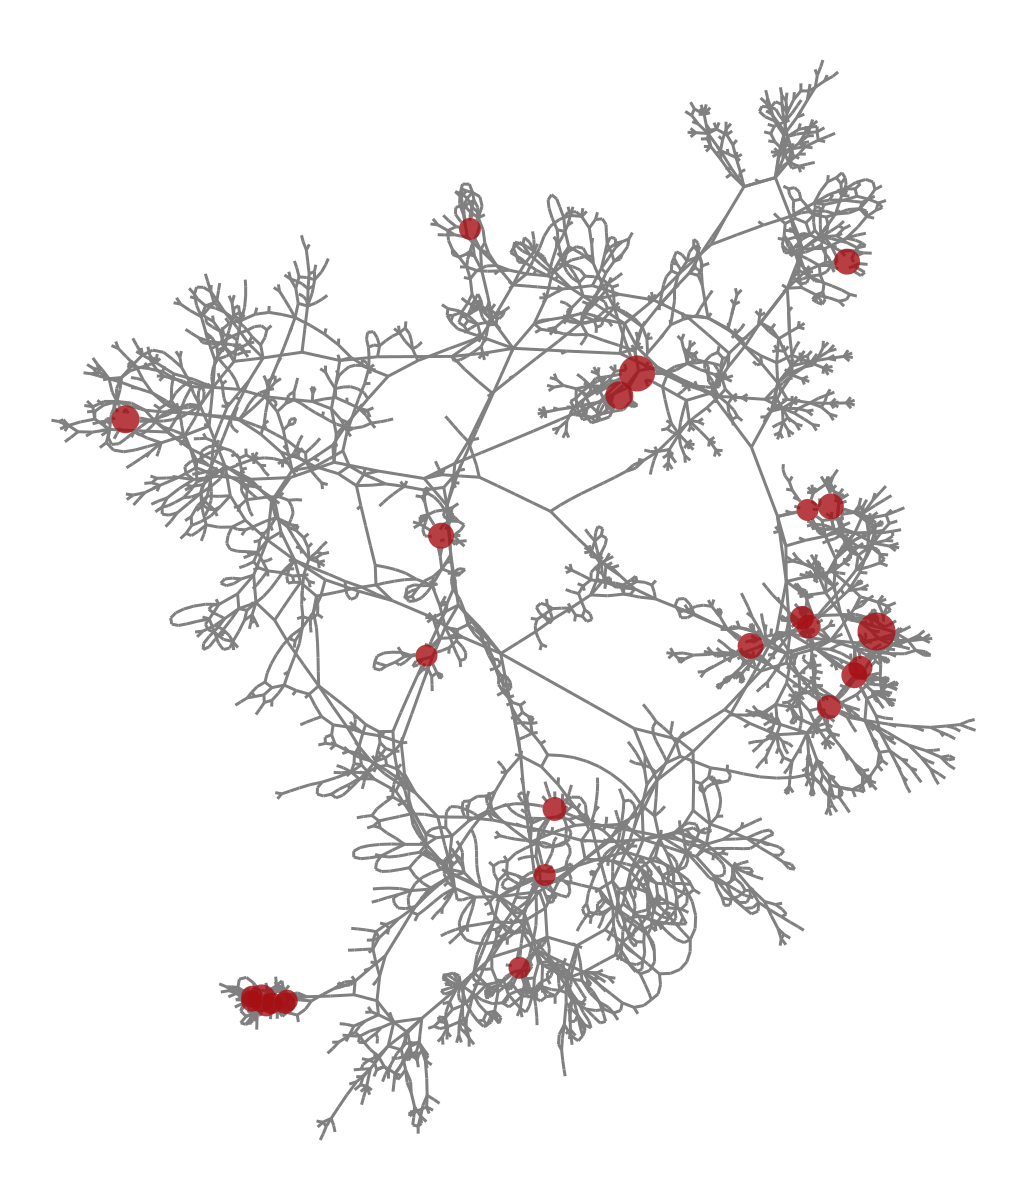

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f490874f050, at 0x7f48456a16d0>

In [3]:
# TODO
# Calculate the degree for each node
degrees = g.degree_property_map("out")

# Create a new vertex property for vertex sizes
vsize = g.new_vertex_property("double")

# Set the size of nodes of no more than 10 to 0
for v in g.vertices():
    vsize[v] = degrees[v] if degrees[v] > 10 else 0

pos = gt.sfdp_layout(g)
gt.graph_draw(g, pos=pos, vertex_size=vsize, edge_pen_width=1.5, edge_color='gray')

**Task 1b:** Identify one of the centrality measures that can be used to indicate powerlines that act as a bridge between different parts of the network. Use this to emphasize structurally important nodes and powerlines.

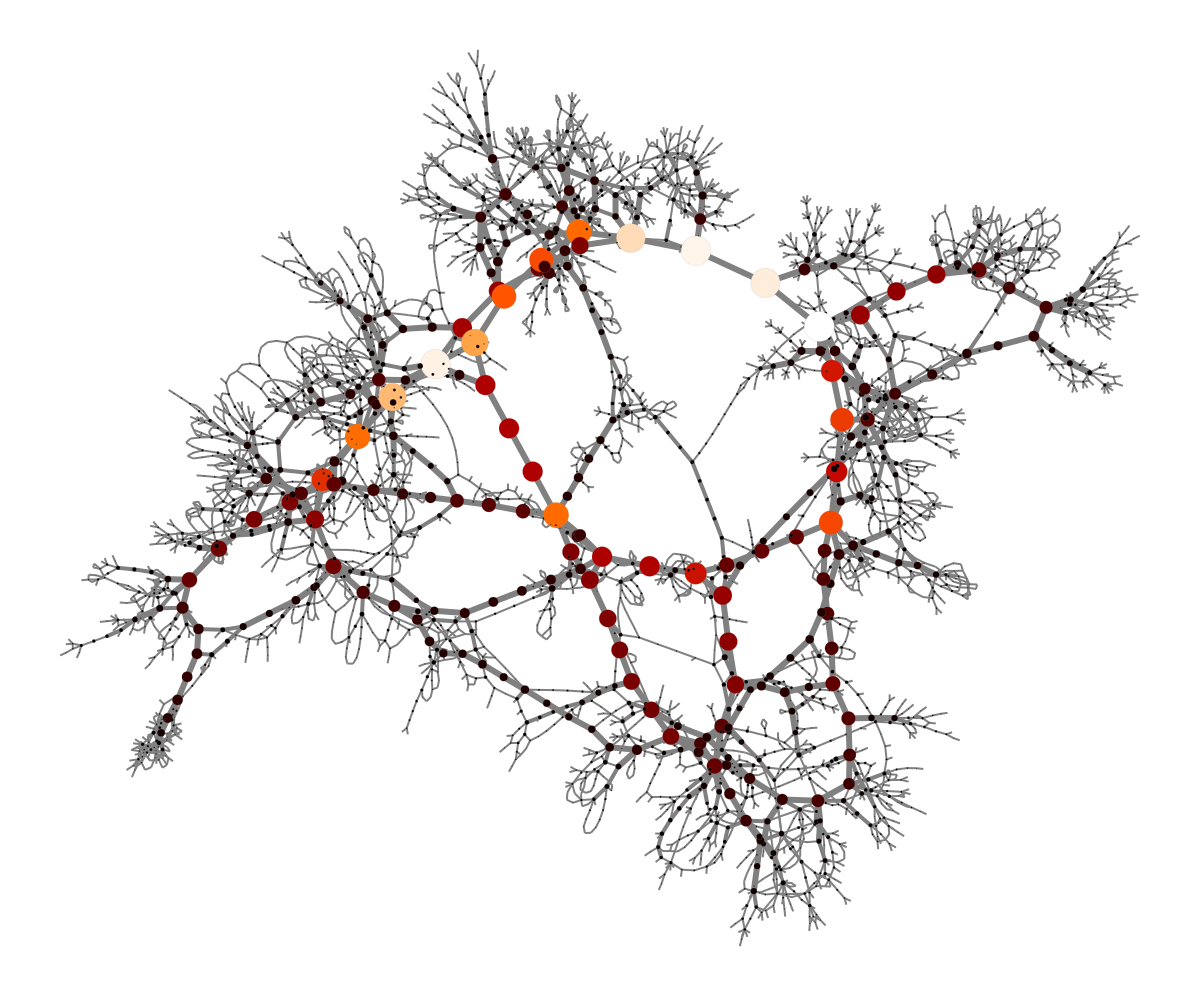

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f490874f050, at 0x7f4846561c50>

In [4]:
# TODO
vb, eb = gt.betweenness(g)

# Vertex setting
vb_array = np.array([vb[v] for v in g.vertices()])
percentile_70 = np.percentile(vb_array, 70)
new_vb = g.new_vertex_property("double")
for v, value in zip(g.vertices(), vb_array):
    new_vb[v] = 0 if value < percentile_70 else value
    
# Edge setting
eb_array = np.array([eb[e] for e in g.edges()])
percentile_90 = np.percentile(eb_array, 90)
percentile_95 = np.percentile(eb_array, 95)
new_eb = g.new_edge_property("float")
for e, value in zip(g.edges(), eb_array):
    new_eb[e] = 1 if value < percentile_90 else 2 if value < percentile_95 else 3

pos = gt.sfdp_layout(g)
gt.graph_draw(g, pos=pos, 
              vertex_size=gt.prop_to_size(vb, 0, 15), 
              vertex_fill_color=new_vb,
              edge_pen_width=new_eb, 
              edge_color='gray',
              vcmap=mpl.cm.gist_heat)

# Problem 2: Small social graph visualization

In [5]:
X_knows = {
    'Mary': ['Peter', 'Albert', 'DavidF', 'Peter'],
    'Judy': ['Bob', 'Alan'],
    'Peter': ['Mary', 'DavidF', 'Jon'],
    'DavidF': ['Albert', 'Joseph', 'Peter', 'Mary'],
    'Jon': ['Peter', 'Joseph', 'DavidE'],
    'DavidE': ['Jon', 'Joseph', 'Albert'],
    'Joseph': ['DavidE', 'Jon', 'DavidF'],
    'Bob': ['Judy', 'Alan'],
    'Alan': ['Bob', 'Mary', 'Judy'],
    'Albert': ['DavidF', 'Mary', 'DavidE'],
}

**Task**: Create an undirected graph that represents the personal network above, remove parallel edges, and draw using a layout that resembles the tidy example as shown further below.

In [6]:
# TODO adjust the code below and add to it

g = gt.Graph(directed=False)
v_name = g.add_edge_list(((n,k) for n in X_knows for k in X_knows[n]),
                         hashed=True)
pos = gt.random_layout(g)
au.rotate_layout(pos, "Alan", "Mary", v_name)

gt.remove_parallel_edges(g) # Remove parallel edges
pos = gt.sfdp_layout(g) # Use stdp layout

vprops = {
    # TODO find suitable vertex properties for graph_draw (see gt reference docs)
    'text': v_name,
    'font_size': 7,
    'size': 30,    
}


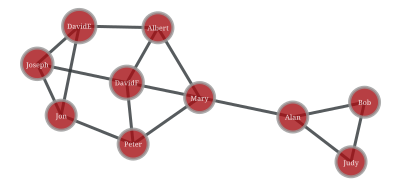

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f484659e190, at 0x7f4845701e50>

In [7]:
gt.graph_draw(
    g,
    pos=pos,
    vprops=vprops,
    output_size=(400,300), # adjust to fit screen
    fit_view=.9,
    fmt="svg"
)

After adjusting the code above you should be able to obtain a 'tidy' result like this.
![](graph.svg)

# Problem 3: Facebook graph analysis

For this question we will work with a real social graph of facebook friendship connections. Please download [`facebook_combined.txt` from SNAP](https://snap.stanford.edu/data/ego-Facebook.html), the Stanford Large Network Dataset Collection and create a `Graph` object with `graph-tool`. The dataset contains the ego networks of 10 facebook users, i.e. it contains the ego nodes, the friends of each of these facebook users, and the connections among those friends.

Goal below is to determine influencers among the users, based on a measure of centrality and not including the ego nodes themselves.

**Task 3a:** Load the dataset and create a drawing of the graph.

In [8]:
# TODO
# Make the graph
file_path = 'facebook_combined.txt'
g = gt.Graph(directed=False)
name_to_vertex = {}

with open(file_path, 'r') as file:
    for line in file:
        # Split the line into source and target node names
        src_name, tgt_name = line.strip().split()

        # Add vertices if they don't exist
        if src_name not in name_to_vertex:
            name_to_vertex[src_name] = g.add_vertex()
        if tgt_name not in name_to_vertex:
            name_to_vertex[tgt_name] = g.add_vertex()

        # Add an edge between the source and target
        g.add_edge(name_to_vertex[src_name], name_to_vertex[tgt_name])


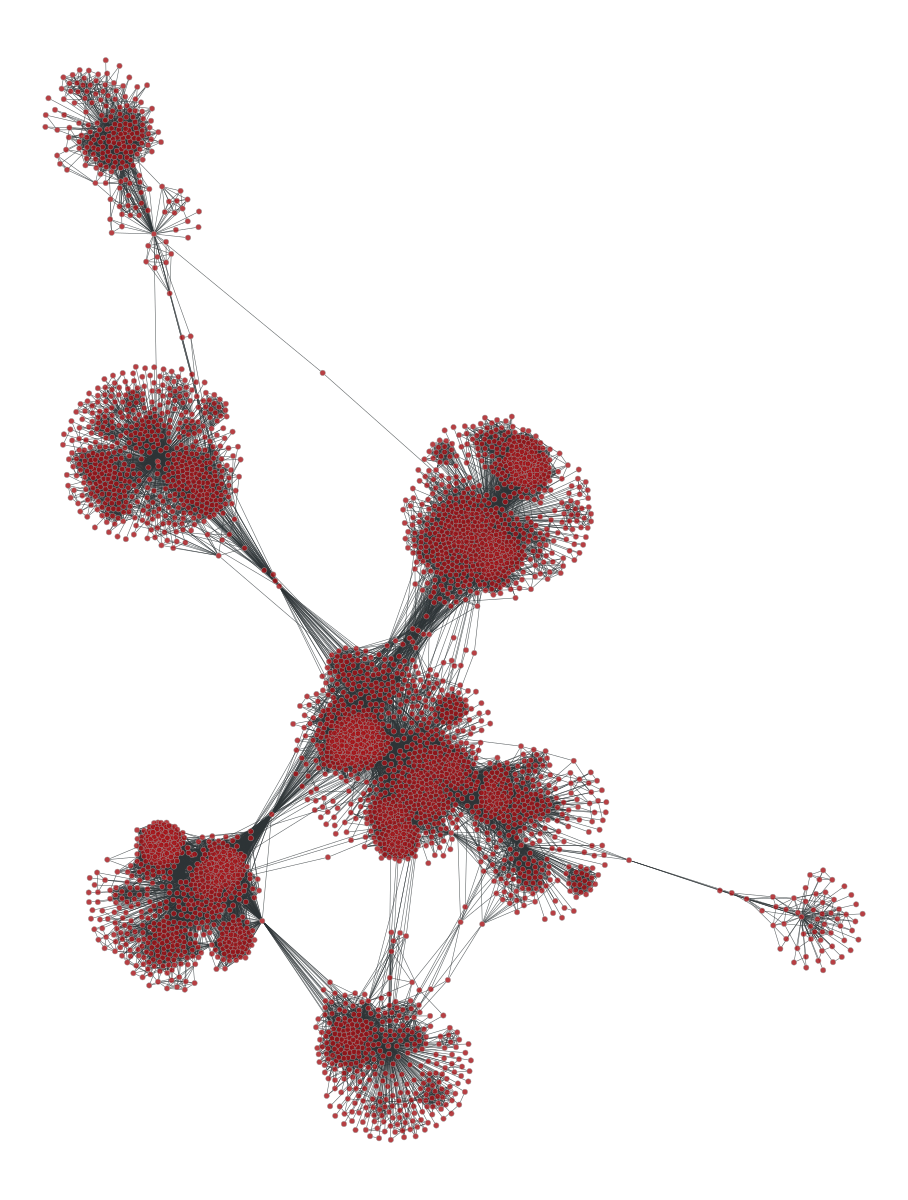

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4846585150, at 0x7f484571f890>

In [9]:
# TODO
# g = gt.collection.ns["ego_social/facebook_combined"] # Load the graph directly
gt.graph_draw(g)

**Task 3b:** Calculate and show a histogram of pairwise distances among users. Internally, this distance would be computed for the shortest path of connections among any pair of users.

Use a log-scale of the frequencies to scale the histogram bars.

What is the diameter of this graph?

*Hint:* Calculating and drawing the histograms amounts to two lines of code using `gt` and `plt` modules.

Diameter of the graph: 8


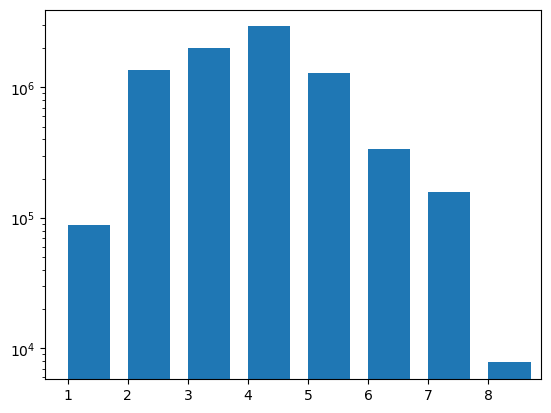

In [10]:
# TODO
dist_matrix = gt.shortest_distance(g)

distances = []
for i in range(g.num_vertices()):
    for j in range(i + 1, g.num_vertices()):
        distances.append(dist_matrix[i][j])

print('Diameter of the graph:', np.max(distances))
            
plt.hist(distances, log=True, width = 0.7, bins=[1, 2, 3, 4, 5, 6, 7, 8, 8.5]);

**Task 3c:** Determine influencers, i.e. people withing the ego network that are well connected among friends.

There are several steps to this analysis. First, remove the ego nodes. You can do this in an approximate way, simply by calculating a measure of influence of a user and removing the highest scoring nodes, assuming that these naturally are the ego nodes whose friends this network consists of.

Use `PageRank` as a measure of influence of a node.

*Step 1* - Create a drawing of a GraphView that only retains nodes with a `pagerank` $< 0.002$.

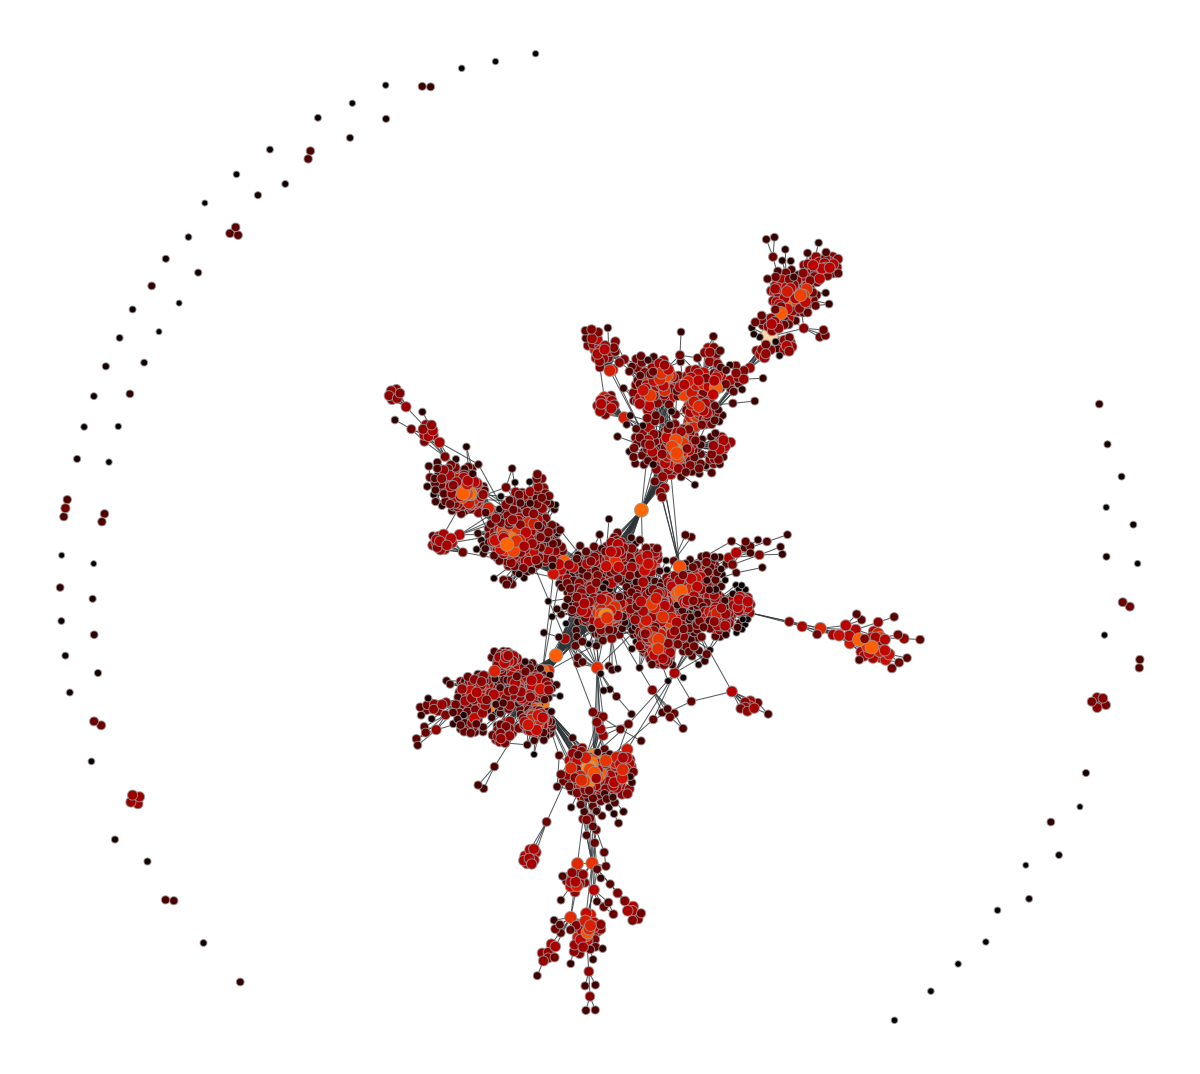

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f483a5d12d0, at 0x7f478a8c5b50>

In [11]:
# TODO
pr = gt.pagerank(g)
g.vp['pr'] = pr

threshold = 0.002
bool_pr = g.vp['pr'].a<threshold
u = gt.GraphView(g, vfilt=bool_pr)

v_size = gt.prop_to_size(u.vp['pr'], mi=3, ma=10)

v_color = u.new_vertex_property("double")
for v in u.vertices():
  v_color[v] = np.log10(u.vp['pr'][v])

gt.graph_draw(u, 
              vertex_size=v_size,
              vertex_fill_color=v_color,
              vcmap=mpl.cm.gist_heat,
              output_size=(600, 600),)

*Step 2* - Only retain the largest connected component of this graph, i.e. create another [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) of only this largest component.

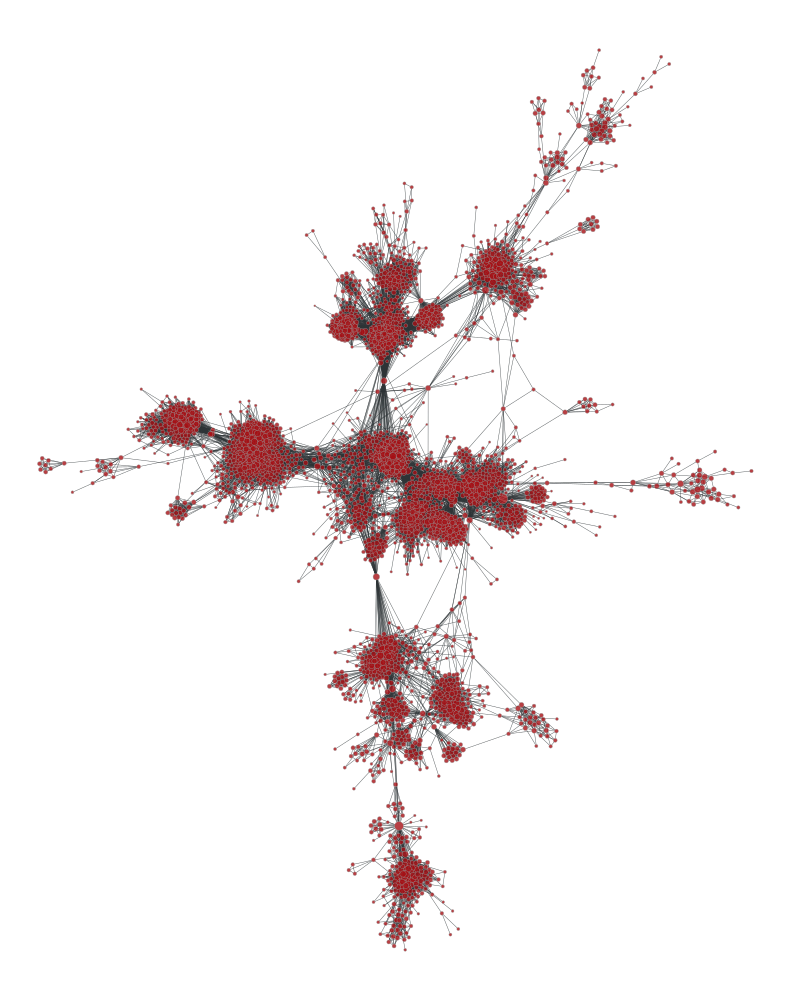

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f483a53d890, at 0x7f483be87350>

In [12]:
# TODO
u_largest = gt.extract_largest_component(u)
w = gt.GraphView(u_largest)

v_size = gt.prop_to_size(w.vp['pr'], mi = 1,ma = 5,)
gt.graph_draw(w, vertex_size=v_size,
              output_size=(500, 500),)

*Step 3* - Recalculate pagerank for each node, choose a threshold (e.g. 0.0005) above which only a small part of the users are selected. Create a drawing that emphasizes these users that play central roles among their friends.

In [13]:
# TODO
t_rank = gt.pagerank(w)

threshold_1 = 0.0005
t_rank.a[t_rank.a <= threshold_1] = 0
w.vp['t_rank'] = t_rank

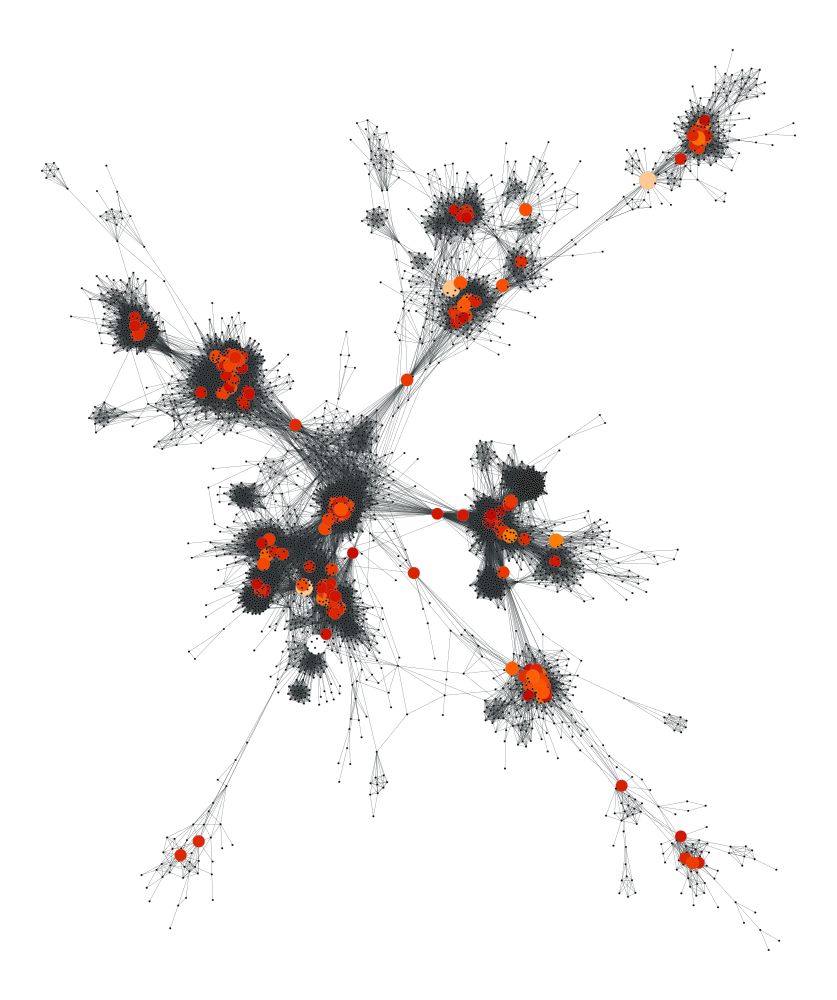

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f483a53d890, at 0x7f483a537710>

In [14]:
# TODO
v_size = gt.prop_to_size(w.vp['t_rank'], mi = 1, ma = 10)

v_color = w.new_vertex_property("double")
for v in w.vertices():
  v_color[v] = np.log(w.vp['t_rank'][v]) if w.vp['t_rank'][v] > 0 else -9

gt.graph_draw(w,vertex_size=v_size,
              vertex_fill_color=v_color,
              vcmap=mpl.cm.gist_heat,
              output_size=(500, 500),)

# Environment setup details

[Setup instruction](https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions#installation-via-package-managers) are available for most environments. To use the setup in the lab, see below.

We have prepared a `conda` environment in the lab that contains all modules required for this assignment. You can activate the environment as follows:

```
conda activate /usr/shared/CMPT/big-data/condaenv/nn11
```

#### You might get an error
`CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.`
This happens, if you have not used conda before. To perform initialization once, we recommend the following steps:
```
cd /usr/shared/CMPT/big-data/miniforge3/bin
./conda init bash
./conda config --set auto_activate_base false
```
If you now restart your terminal shell or simply invoke a new one by typing `bash`, you can try activating the environment, again.

# Submission instructions
Please submit this A7.ipynb notebook
to [CourSys](https://coursys.sfu.ca/2024sp-cmpt-733-g1/+a7/),
filled out with figures included.